In [182]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate


In [ ]:
load_dotenv()
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# 🔎 Setup embedding model and vector store
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
index_name = "healthguru"
docsearch = PineconeVectorStore.from_existing_index(index_name=index_name, embedding=embeddings)
retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 5})


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\anand\\Desktop\\healthguru\\Chatbot\\venv\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\anand\\Desktop\\healthguru\\Chatbot\\venv\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference


In [241]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=0.3,
    max_tokens=1024,
    timeout=60,
)

In [184]:

template = """
"You are HealthGuru helpful health assistant providing accurate information and suggestions regarding health,
diseases,treatments and general health tips .\n\n"
"if the enough info not available then use websearch agent to answer the query"

Answer the user query based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


rag_chain = prompt | llm

In [185]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langchain_community.tools.tavily_search import TavilySearchResults 


In [186]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    enhanced_query: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage

In [187]:
class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )

In [188]:
class Greetings(BaseModel):
    greeting: str = Field(
        description="is it Greeting from the user? If yes -> 'Yes' if not -> 'No'"
    )

In [189]:
def query_enhancer(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["enhanced_query"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        # print(f"query_enhancer: Rephrased question: {better_question}")
        state["enhanced_query"] = better_question
    else:
        state["enhanced_query"] = state["question"].content
    return state

In [190]:
def query_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about the following health-related topics:
    
    0. health-related topics
    1. Symptoms and causes of diseases (e.g., diabetes, hypertension, etc.)
    2. Treatment options and medications
    3. Preventive healthcare (e.g., vaccinations, screenings)
    4. Diet and nutrition advice
    5. Exercise and fitness recommendations
    6. Mental health and well-being
    7. General healthcare information or healthy lifestyle tips
    8. Health technology and innovations (e.g., telemedicine, health apps)
    
    If the question IS about any of these topics, respond with 'Yes'.
    If the query is about Greetings and salutations and Asking about you and your concern(e.g., "Hello", "Hi", "Good morning" etc) respond with 'greeting'. Otherwise, respond with 'No'.
    
    """
    )


    human_message = HumanMessage(
        content=f"User question: {state['enhanced_query']}\n\n"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

In [191]:
def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    elif on_topic == "greeting":
        print("Routing to greeting_response")
        return "greeting_response"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

In [192]:
def greeting_response(state: AgentState):
    print("Entering greeting_response")
    state['proceed_to_generate'] = True
    state["documents"] = []
    return state

In [193]:
def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["enhanced_query"])
    # print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state

In [194]:
class GradeDocument(BaseModel):
    score: str = Field(
        ...,
        description=(
            "Does this document fully or partially answer the user's query?\n"
            "Answer 'Yes' if the document contains relevant, useful, or directly related information.\n"
            "Answer 'No' if the document does not help answer the query or is off-topic.\n"
        )
    )

In [195]:
def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
    content="""
    You are a grader assessing the relevance of a retrieved document to a user question.
    Respond only with 'Yes' or 'No'.

    Respond 'Yes' only if the document directly answers the user's question AND is on the correct topic.

    Do NOT respond 'Yes' if:
    - The document discusses unrelated diseases or topics (e.g., HIV vs COVID-19).
    - The symptoms mentioned are general and not clearly tied to the topic in the question.
    - The document content is ambiguous or off-topic.

    Be strict. Respond 'No' if unsure.
    """
)

    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['enhanced_query']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        # print(
        #     f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        # )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

In [196]:
def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)

    if state.get("proceed_to_generate", False):
        print("Relevant documents found. Routing to generate_answer.")
        return "generate_answer"
    
    if rephrase_count >= 2:
        print("No relevant docs and rephrased 2 times. Routing to websearch.")
        return "websearch"
    
    print("No relevant docs. Will try refining the query.")
    return "refine_query"


In [197]:
def refine_query(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        # print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["enhanced_query"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["enhanced_query"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

In [198]:
def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_query = state["enhanced_query"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_query}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"HealthGuru: {generation}")
    return state

In [199]:
tavily_search = TavilySearchResults(max_results=3)

In [200]:
def websearch(state: AgentState):
    print("Entering web_search fallback")
    
    tavily_tool = TavilySearchResults()
    try:
        results = tavily_tool.invoke({"query": state["enhanced_query"]})
    except Exception as e:
        print(f"web_search: Tavily API failed - {e}")
        state["documents"] = []
        state["proceed_to_generate"] = False
        return state

    if not results:
        print("web_search: No results returned from Tavily.")
        state["documents"] = []
        state["proceed_to_generate"] = False
        return state

    docs = [
        Document(
            page_content=res["content"],
            metadata={"source": res["url"], "source_type": "websearch"}
        )
        for res in results if res.get("content")
    ]

    print(f"From the websearch")
    # print(docs)

    state["documents"] = docs
    state["proceed_to_generate"] = len(docs) > 0
    return state


In [201]:
def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics."))
    return state



In [202]:
def clear_state(state: AgentState):
    state["messages"] = []
    state["documents"] = []
    state["on_topic"] = ""
    state["enhanced_query"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

# create state
agent_state: AgentState = {
    "messages": [],
    "documents": [],
    "on_topic": "",
    "enhanced_query": "",
    "proceed_to_generate": False,
    "rephrase_count": 0
}

# clear state
clear_state(agent_state)

In [203]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [222]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("query_enhancer", query_enhancer)
workflow.add_node("query_classifier", query_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_query", refine_query)
workflow.add_node("websearch", websearch)
workflow.add_node("greeting_response", greeting_response)

workflow.add_edge("query_enhancer", "query_classifier")
workflow.add_conditional_edges(
    "query_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
        "greeting_response": "greeting_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_query": "refine_query",
        "websearch": "websearch",
    },
)
workflow.add_edge("greeting_response", "generate_answer")
workflow.add_edge("refine_query", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("websearch", "generate_answer" )
workflow.add_edge("off_topic_response", "generate_answer")
workflow.set_entry_point("query_enhancer")
app = workflow.compile(checkpointer=checkpointer)

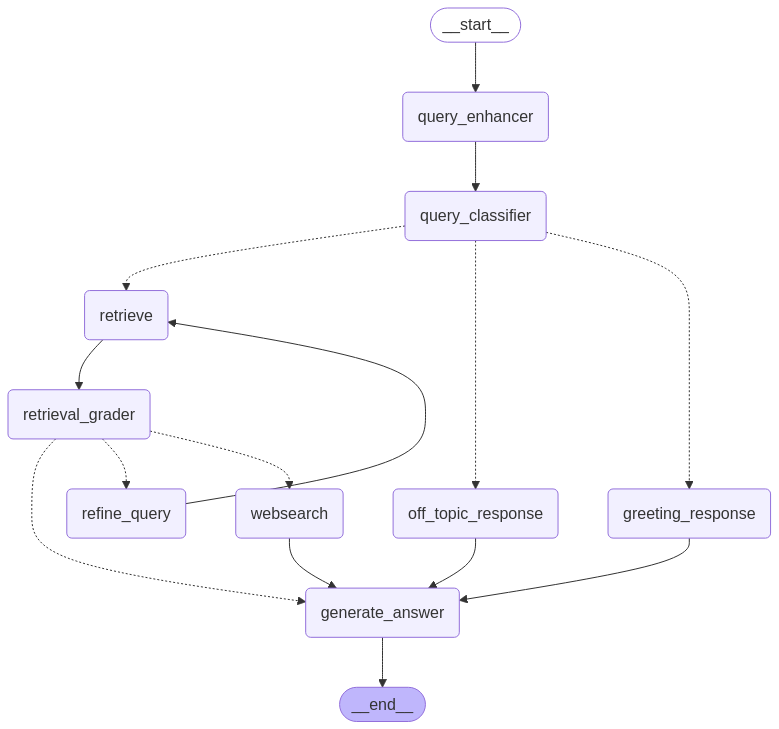

In [223]:
from IPython .display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [206]:
input_data = {
    "question": HumanMessage(content="the first body part that stops when humans die?")
}
response=app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(response)

Entering question_rewriter with following state: {'question': HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response
{'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'enhanced_query': 'the first body part that stops when humans die?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={})}


In [207]:
input_data = {
    "question": HumanMessage(content="what changes needs to bring in his lifestyle?")
}
response=app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(response)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'enhanced_query': 'the first body part that stops when humans die?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='what changes needs to bring in his lifestyle?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
Entering retrieval_grader
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Relevant documents found. Routing to generate_answer.
Entering generate_answer
HealthGuru: To improve someone's health, several lifestyle changes can be beneficial:

*   **Die

In [208]:
input_data = {
    "question": HumanMessage(content="what meditions needs to take?")
}
response=app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(response)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={}), HumanMessage(content='what changes needs to bring in his lifestyle?', additional_kwargs={}, response_metadata={}), AIMessage(content="To improve someone's health, several lifestyle changes can be beneficial:\n\n*   **Dietary modifications:** This includes reducing carbohydrates and fats while increasing the intake of fruits and vegetables. A healthcare professional, such as a dietician, can help calculate specific dietary requirements.\n*   **Increased physical activity:** Aim for at least 30 minutes of brisk walking at least three times a week. Regular exercise, such as sports or gym activities, is also recommended.\n*   **Reduced alcohol consumption:** It's encouraged to

In [209]:
input_data = {
    "question": HumanMessage(content="how much sperm a healthy person release")
}
response=app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(response)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={}), HumanMessage(content='what changes needs to bring in his lifestyle?', additional_kwargs={}, response_metadata={}), AIMessage(content="To improve someone's health, several lifestyle changes can be beneficial:\n\n*   **Dietary modifications:** This includes reducing carbohydrates and fats while increasing the intake of fruits and vegetables. A healthcare professional, such as a dietician, can help calculate specific dietary requirements.\n*   **Increased physical activity:** Aim for at least 30 minutes of brisk walking at least three times a week. Regular exercise, such as sports or gym activities, is also recommended.\n*   **Reduced alcohol consumption:** It's encouraged to

In [242]:
input_data = {
    "question": HumanMessage(content="what if more than that?")
}
response=app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(response)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={}), HumanMessage(content='what changes needs to bring in his lifestyle?', additional_kwargs={}, response_metadata={}), AIMessage(content="To improve someone's health, several lifestyle changes can be beneficial:\n\n*   **Dietary modifications:** This includes reducing carbohydrates and fats while increasing the intake of fruits and vegetables. A healthcare professional, such as a dietician, can help calculate specific dietary requirements.\n*   **Increased physical activity:** Aim for at least 30 minutes of brisk walking at least three times a week. Regular exercise, such as sports or gym activities, is also recommended.\n*   **Reduced alcohol consumption:** It's encouraged to

In [212]:
input_data = {
    "question": HumanMessage(content="what is cancer")}
response=app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(response)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={}), HumanMessage(content='what changes needs to bring in his lifestyle?', additional_kwargs={}, response_metadata={}), AIMessage(content="To improve someone's health, several lifestyle changes can be beneficial:\n\n*   **Dietary modifications:** This includes reducing carbohydrates and fats while increasing the intake of fruits and vegetables. A healthcare professional, such as a dietician, can help calculate specific dietary requirements.\n*   **Increased physical activity:** Aim for at least 30 minutes of brisk walking at least three times a week. Regular exercise, such as sports or gym activities, is also recommended.\n*   **Reduced alcohol consumption:** It's encouraged to

In [ ]:
def clear_state(state: AgentState):
    state["messages"] = []
    state["documents"] = []
    state["on_topic"] = ""
    state["enhanced_query"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

# create state
agent_state: AgentState = {
    "messages": [],
    "documents": [],
    "on_topic": "",
    "enhanced_query": "",
    "proceed_to_generate": False,
    "rephrase_count": 0
}

# clear state
clear_state(agent_state)

In [239]:
import base64
import requests
import io
from PIL import Image
from dotenv import load_dotenv
import os
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()
GROQ_API_URL = "https://api.groq.com/openai/v1/chat/completions"
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("GROQ API KEY is not set in the .env file")

def describe_image(image_path):
    """
    Takes an image file path and returns a 1–2 line description about the image
    focused on health-related topics, or a fallback response if not health-related.
    """
    try:
        with open(image_path, "rb") as image_file:
            image_content = image_file.read()
            encoded_image = base64.b64encode(image_content).decode("utf-8")

        # Check image validity
        try:
            img = Image.open(io.BytesIO(image_content))
            img.verify()
        except Exception as e:
            logger.error(f"Invalid image format: {str(e)}")
            return {"error": f"Invalid image format: {str(e)}"}

        # Vision prompt: keep response short and useful for chaining
        prompt_text = (
         "What does this image show? "
         "describe it in a 1-2 line query strictly including the main context.\n\n"
         "Examples:\n"
         "- If the image shows a person with a headache, respond: 'person has a problem with headache'.\n"
         "- If the image shows scalp issues, respond: 'person has a problem with scalp in the head'.\n"
         "- If the image shows medicine packaging, respond like: 'The medicine name is [medicine_name], and main description given on the package'."
         "-whatever its about describes just return in one line"
         "like this only give short description"
)

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
                ]
            }
        ]

        # Make the request to Groq API
        response = requests.post(
            GROQ_API_URL,
            json={
                "model": "llama-3.2-90b-vision-preview",
                "messages": messages,
                "max_tokens": 500
            },
            headers={
                "Authorization": f"Bearer {GROQ_API_KEY}",
                "Content-Type": "application/json"
            },
            timeout=30
        )

        response.raise_for_status()
        data = response.json()
        description = data.get("choices", [{}])[0].get("message", {}).get("content", "No description found.")

        return {"description": description.strip()}

    except Exception as e:
        logger.error(f"Error: {str(e)}")
        return {"error": str(e)}

# Run and test the function
if __name__ == "__main__":
    image_path = "c.jpeg"  # Replace with your test image
    result = describe_image(image_path)

    if "error" in result:
        print("Error:", result["error"])
    else:
        query = result["description"]
        print("Image Description:", query)
        
        # Create the input data for invoking the system
        


Image Description: It shows the Novel Coronavirus (COVID-19).


In [243]:
input_data = {
            "question": HumanMessage(content=query)
        }

        # Assuming `app.invoke()` is a part of your system for processing
response = app.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
        
        # Printing the response after invoking
print(response)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='the first body part that stops when humans die?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I am an health assistant Please ask realted to health topics.", additional_kwargs={}, response_metadata={}), HumanMessage(content='what changes needs to bring in his lifestyle?', additional_kwargs={}, response_metadata={}), AIMessage(content="To improve someone's health, several lifestyle changes can be beneficial:\n\n*   **Dietary modifications:** This includes reducing carbohydrates and fats while increasing the intake of fruits and vegetables. A healthcare professional, such as a dietician, can help calculate specific dietary requirements.\n*   **Increased physical activity:** Aim for at least 30 minutes of brisk walking at least three times a week. Regular exercise, such as sports or gym activities, is also recommended.\n*   **Reduced alcohol consumption:** It's encouraged to